<img src="https://posgrado.utec.edu.pe/sites/default/files/2023-08/Testimonial-home-2.jpg" alt="HTML5 Icon" width="900" height="250" >

# **Laboratorio: Advanced Data Cleaning and Feature Transformation with House Prices Dataset**

---

## **Objetivo general**

Aplicar técnicas avanzadas de limpieza de datos, codificación de variables categóricas, discretización y transformaciones numéricas (incluyendo polinómicas) sobre un dataset real para preparar la información antes del modelado.


## **1. Introducción teórica**

En cualquier proyecto de ciencia de datos, **la etapa de preprocesamiento puede ocupar hasta el 80% del tiempo total.** Esto se debe a que los datos rara vez vienen listos para usarse: suelen tener errores, valores faltantes, formatos inconsistentes y escalas incompatibles.


La limpieza avanzada no se limita a eliminar nulos o duplicados, sino que abarca tareas más profundas como:


- Detectar inconsistencias semánticas (mismo valor escrito de forma distinta).

- Estandarizar formatos (fechas, unidades de medida, codificación de texto).

- Identificar y tratar outliers que afectan análisis y modelos.

- Aplicar transformaciones matemáticas para mejorar la distribución de las variables y la capacidad predictiva de los modelos.

## **2. Carga y exploración inicial del dataset**

Usaremos el dataset House Prices – Advanced Regression Techniques de Kaggle.

In [162]:
!pip install kaggle -q
!pip install category_encoders -q

In [163]:
import os
from google.colab import userdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures, LabelEncoder, MinMaxScaler, StandardScaler
import category_encoders as ce

In [164]:
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

In [198]:
COMPETITION_NAME = 'house-prices-advanced-regression-techniques'
DATA_DIR = './house-prices'

# Descarga los datos de la competencia
!kaggle competitions download -c {COMPETITION_NAME}

# Crea el directorio de destino y descomprime los archivos
!mkdir -p {DATA_DIR}
!unzip {COMPETITION_NAME}.zip -d {DATA_DIR}

print(f"Datos descargados y descomprimidos en la carpeta '{DATA_DIR}'")

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  house-prices-advanced-regression-techniques.zip
replace ./house-prices/data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./house-prices/data_description.txt  
  inflating: ./house-prices/sample_submission.csv  
  inflating: ./house-prices/test.csv  
  inflating: ./house-prices/train.csv  
Datos descargados y descomprimidos en la carpeta './house-prices'


In [199]:
print("Archivos disponibles:")
!ls {DATA_DIR}

# Carga el archivo de entrenamiento en un DataFrame de Pandas
try:
    df = pd.read_csv(f'{DATA_DIR}/train.csv')
    print("\nCarga exitosa.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo train.csv en el directorio {DATA_DIR}")

Archivos disponibles:
data_description.txt  sample_submission.csv  test.csv  train.csv

Carga exitosa.


In [200]:
df_original = df.copy()

In [201]:
# Dimensiones y primeras filas
print(df.shape)
df.head()

# Información general
df.info()

# Resumen estadístico
df.describe()


(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## **3. Limpieza avanzada de datos**



**3.1 Detección de valores faltantes**

In [202]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)


,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageType,81
GarageYrBlt,81
GarageFinish,81


Aquí detectamos columnas con valores faltantes. Algunos datasets codifican los nulos como “NA” o “0” en lugar de NaN, por lo que también conviene revisar valores únicos por columna.

**3.2 Imputación de valores**



Numéricos – usando la mediana para evitar el efecto de outliers:

In [203]:
num_imputer = SimpleImputer(strategy='median')
df['LotFrontage'] = num_imputer.fit_transform(df[['LotFrontage']])


Categóricos – usando la moda o creando una categoría “Missing”:

In [204]:
cat_imputer = SimpleImputer(strategy='most_frequent')
df['MasVnrType'] = cat_imputer.fit_transform(df[['MasVnrType']]).ravel()

In [205]:
df['MasVnrType'].unique()

array(['BrkFace', 'Stone', 'BrkCmn'], dtype=object)

> Usar media puede distorsionar si hay valores extremos.
>
> Usar mediana es más robusto frente a outliers.
>
> Para categóricos, asignar “Missing” puede conservar la información de que el valor no estaba registrado.

**3.3 Corrección de inconsistencias de formato**

In [206]:
df['Neighborhood'] = df['Neighborhood'].str.strip().str.title()


Esto asegura consistencia en mayúsculas/minúsculas y elimina espacios extra.



**3.4 Duplicados exactos y casi-duplicados**


In [207]:
df.drop_duplicates(inplace=True)


**3.5 Outliers**

Usaremos el rango intercuartílico (IQR):

In [208]:
Q1 = df['SalePrice'].quantile(0.25)
Q3 = df['SalePrice'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['SalePrice'] < Q1 - 1.5*IQR) | (df['SalePrice'] > Q3 + 1.5*IQR)]
outliers.shape


(61, 81)

In [209]:
outliers.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
11,12,60,RL,85.0,11924,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,345000
53,54,20,RL,68.0,50271,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,11,2006,WD,Normal,385000
58,59,60,RL,66.0,13682,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,10,2006,New,Partial,438780
112,113,60,RL,77.0,9965,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,383970
151,152,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,New,Partial,372402


Outliers detectados no siempre deben eliminarse: en precios de casas, un valor alto puede ser legítimo.

## **4. Codificación de variables categóricas**

**4.1 One-Hot Encoding**

Convierte categorías en columnas binarias.

In [210]:
df = pd.get_dummies(df, columns=['Neighborhood'], drop_first=True)


**4.2 Label Encoding**

Asigna un número entero a cada categoría (útil para variables ordinales).

In [211]:
le = LabelEncoder()
df['Street'] = le.fit_transform(df['Street'])


**4.3 Target Encoding (avanzado, riesgo de data leakage)**

In [212]:
te = ce.TargetEncoder(cols=['MSZoning'])
df['MSZoning'] = te.fit_transform(df['MSZoning'], df['SalePrice'])


In [213]:
df['MSZoning']

,MSZoning
0,191004.994787
1,191004.994787
2,191004.994787
3,191004.994787
4,191004.994787
...,...
1455,191004.994787
1456,191004.994787
1457,191004.994787
1458,191004.994787


## **5. Discretización de variables continuas**

Reduce una variable continua a intervalos o “bins”.

In [214]:
from sklearn.preprocessing import KBinsDiscretizer

kb = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df['SalePrice_bin'] = kb.fit_transform(df[['SalePrice']])


Útil cuando queremos reducir la sensibilidad del modelo a variaciones pequeñas o cuando la variable tiene relación no lineal con la respuesta.

## **6. Transformaciones numéricas avanzadas**


**6.1 Transformación logarítmica**


Reduce asimetría en variables sesgadas a la derecha.

In [215]:
import numpy as np
df['SalePrice_log'] = np.log1p(df['SalePrice'])


**6.2 Min–Max Scaling**

Escala los valores a un rango fijo [0, 1].

In [216]:
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
df[['LotArea_mm', 'GrLivArea_mm']] = mm_scaler.fit_transform(df[['LotArea', 'GrLivArea']])


**6.3 Z-score Standardization**

Centra en media 0 y desv. estándar 1.

In [217]:


scaler = StandardScaler()
df[['LotArea_z', 'GrLivArea_z']] = scaler.fit_transform(df[['LotArea', 'GrLivArea']])


**6.4 Transformaciones polinómicas**

Genera nuevas variables como combinaciones polinómicas de las existentes.

In [218]:

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['GrLivArea', 'LotArea']])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['GrLivArea', 'LotArea']))

df = pd.concat([df, poly_df], axis=1)


Útil para modelos lineales que no capturan interacciones o curvaturas de forma natural. Ojo: puede aumentar mucho la dimensionalidad.

## **7. Evaluación visual del impacto**


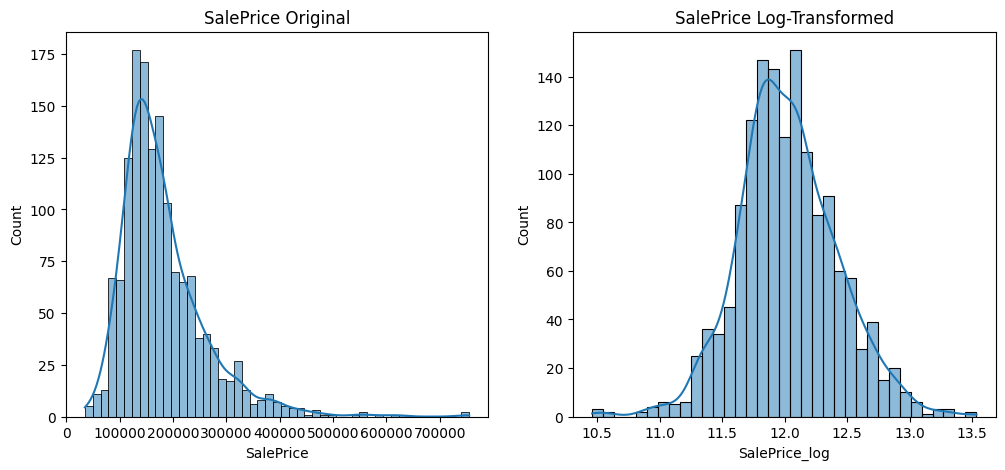

In [219]:

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df['SalePrice'], ax=axes[0], kde=True)
axes[0].set_title("SalePrice Original")
sns.histplot(df['SalePrice_log'], ax=axes[1], kde=True)
axes[1].set_title("SalePrice Log-Transformed")
plt.show()


## **Tarea**

- Identificar y corregir inconsistencias en otra columna categórica.

- Imputar una variable numérica usando media, mediana y KNN, y comparar resultados.

- Comparar One-Hot Encoding vs. Target Encoding en términos de número de columnas y posible overfitting.

- Discretizar LotArea usando equal-width binning.

- Generar transformaciones polinómicas de grado 3 para tres variables numéricas y evaluar cuántas columnas nuevas produce.

### 1. Identificar y corregir inconsistencias en otra columna categórica

El notebook original corrigió ```Neighborhood```. Vamos a inspeccionar y corregir Exterior1st, que representa el revestimiento exterior de la casa. A menudo, estas columnas tienen abreviaturas o entradas similares que pueden ser unificadas.

In [220]:
print("Valores únicos en 'Exterior1st' ANTES de la corrección:")
print(df['Exterior1st'].value_counts())

Valores únicos en 'Exterior1st' ANTES de la corrección:
Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64


In [221]:
# Diccionario para unificar valores
correction_map = {
    'Wd Sdng': 'WoodSiding',
    'WdShing': 'WoodShingling',
    'Brk Cmn': 'BrkComm',
    'CemntBd': 'CementBoard'
}

df['Exterior1st'] = df['Exterior1st'].replace(correction_map)

print("Valores únicos en 'Exterior1st' DESPUÉS de la corrección:")
print(df['Exterior1st'].value_counts())

Valores únicos en 'Exterior1st' DESPUÉS de la corrección:
Exterior1st
VinylSd          515
HdBoard          222
MetalSd          220
WoodSiding       206
Plywood          108
CementBoard       61
BrkFace           50
WoodShingling     26
Stucco            25
AsbShng           20
BrkComm            2
Stone              2
AsphShn            1
ImStucc            1
CBlock             1
Name: count, dtype: int64


Hemos estandarizado los nombres de las categorías en ```Exterior1st```, lo que evitará que el modelo las trate como características distintas.

###2. Imputar una variable numérica y comparar resultados

Vamos a imputar los valores faltantes en ```GarageYrBlt``` (año de construcción del garaje) usando tres estrategias: media, mediana y KNN.

In [222]:
# Copiamos el dataframe para no alterar el original en cada prueba
df_mean = df.copy()
df_median = df.copy()
df_knn = df.copy()

# Imputación con Media
imputer_mean = SimpleImputer(strategy='mean')
df_mean['GarageYrBlt'] = imputer_mean.fit_transform(df_mean[['GarageYrBlt']])

# Imputación con Mediana
imputer_median = SimpleImputer(strategy='median')
df_median['GarageYrBlt'] = imputer_median.fit_transform(df_median[['GarageYrBlt']])

# Imputación con KNN
imputer_knn = KNNImputer(n_neighbors=5) # 5 vecinos es un valor común
df_knn['GarageYrBlt'] = imputer_knn.fit_transform(df_knn[['GarageYrBlt']]) # Usando solo la misma columna

print("Estadísticas de 'GarageYrBlt' Original (sin nulos):")
print(df['GarageYrBlt'].dropna().describe())

Estadísticas de 'GarageYrBlt' Original (sin nulos):
count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64


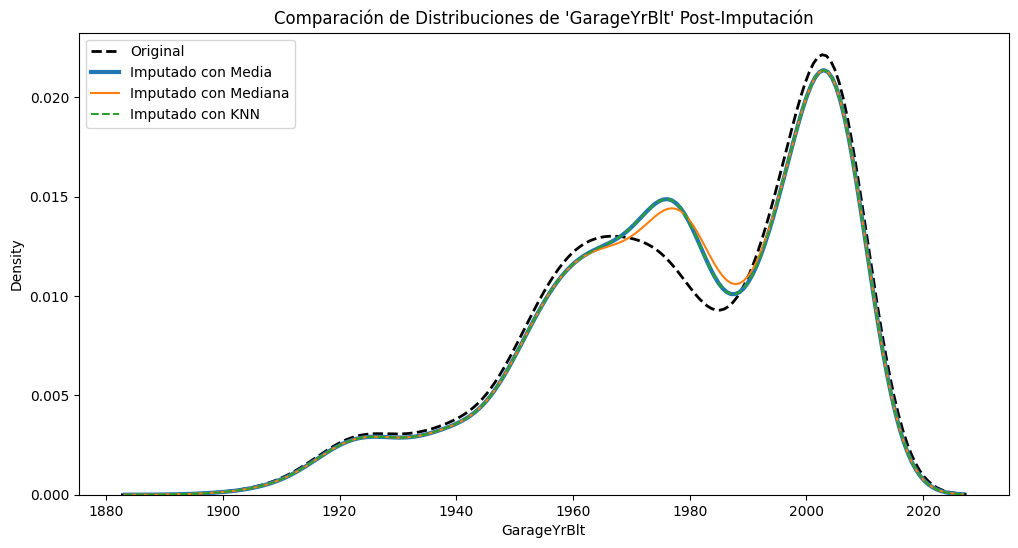


Estadísticas después de la imputación:
Media: count    1460.000000
mean     1978.506164
std        23.994583
min      1900.000000
25%      1962.000000
50%      1978.506164
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

Mediana: count    1460.000000
mean     1978.589041
std        23.997022
min      1900.000000
25%      1962.000000
50%      1980.000000
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

KNN: count    1460.000000
mean     1978.506164
std        23.994583
min      1900.000000
25%      1962.000000
50%      1978.506164
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64


In [223]:
# Comparar las distribuciones visualmente
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(df['GarageYrBlt'].dropna(), ax=ax, label='Original', linewidth=2, color='black', linestyle='--')
sns.kdeplot(df_mean['GarageYrBlt'], ax=ax, label='Imputado con Media', linewidth=3)
sns.kdeplot(df_median['GarageYrBlt'], ax=ax, label='Imputado con Mediana')
sns.kdeplot(df_knn['GarageYrBlt'], ax=ax, label='Imputado con KNN', linestyle='--')

ax.set_title("Comparación de Distribuciones de 'GarageYrBlt' Post-Imputación")
ax.legend()
plt.show()

print("\nEstadísticas después de la imputación:")
print("Media:", df_mean['GarageYrBlt'].describe())
print("\nMediana:", df_median['GarageYrBlt'].describe())
print("\nKNN:", df_knn['GarageYrBlt'].describe())

* Media: Es sensible a outliers. Si la distribución es asimétrica, la media puede no ser representativa del valor central, lo que puede distorsionar ligeramente la distribución original.

* Mediana: Es más robusta a outliers. Generalmente preserva mejor la forma de la distribución original si esta es asimétrica, como es el caso de ```GarageYrBlt```.

* KNN Imputer: Intenta predecir el valor faltante basándose en los valores de sus "vecinos" más cercanos. Cuando se usa en una sola columna, su comportamiento es similar a la imputación por media, pero su verdadero poder radica en usar múltiples columnas para hacer una imputación más inteligente. Visualmente, en este caso simple, no ofrece una gran ventaja sobre la media o mediana.

### 3. Comparar One-Hot Encoding vs. Target Encoding

Usaremos la columna ```Neighborhood```, que tiene 25 categorías diferentes.

In [224]:
df_ohe = pd.get_dummies(df_original, columns=['Neighborhood'], drop_first=True)
ohe_cols = df_ohe.shape[1] - df_original.shape[1] + 1 # +1 para contar la columna eliminada

print(f"One-Hot Encoding:")
print(f"  - Shape original del DataFrame: {df.shape}")
print(f"  - Shape después de OHE: {df_ohe.shape}")
print(f"  - Nuevas columnas creadas: {ohe_cols} (25 categorías -> 24 columnas nuevas)")

One-Hot Encoding:
  - Shape original del DataFrame: (1460, 115)
  - Shape después de OHE: (1460, 104)
  - Nuevas columnas creadas: 24 (25 categorías -> 24 columnas nuevas)


In [225]:
df_te = df_original.copy()
target_encoder = ce.TargetEncoder(cols=['Neighborhood'])
df_te['Neighborhood_encoded'] = target_encoder.fit_transform(df_te['Neighborhood'], df_te['SalePrice'])

print(f"\nTarget Encoding:")
print(f"  - Shape original del DataFrame: {df_original.shape}")
print(f"  - Shape después de Target Encoding: {df_te.shape}")
print(f"  - Nuevas columnas creadas: 1")
print("\nEjemplo de la columna transformada con Target Encoding:")
print(df_te[['Neighborhood', 'Neighborhood_encoded', 'SalePrice']].head())


Target Encoding:
  - Shape original del DataFrame: (1460, 81)
  - Shape después de Target Encoding: (1460, 82)
  - Nuevas columnas creadas: 1

Ejemplo de la columna transformada con Target Encoding:
  Neighborhood  Neighborhood_encoded  SalePrice
0      CollgCr         197965.734807     208500
1      Veenker         197643.209810     181500
2      CollgCr         197965.734807     223500
3      Crawfor         209344.287867     140000
4      NoRidge         318453.591177     250000


OHE es más seguro pero puede crear demasiadas columnas (maldición de la dimensionalidad). Target Encoding es potente y compacto, pero debe usarse con cuidado para evitar el overfitting o data leakage.

### 4. Discretizar ```LotArea``` usando Equal-Width Binning

"Equal-width binning" significa que el rango de cada contenedor es el mismo. En ```KBinsDiscretizer```, esto corresponde a la estrategia ```'uniform'```. Crearemos 5 contenedores.

In [226]:
from sklearn.preprocessing import KBinsDiscretizer

# Inicializar el discretizador
ew_binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Aplicar al DataFrame limpio, usando .ravel()
df=df_original.copy()
df['LotArea_ew_bin'] = ew_binner.fit_transform(df[['LotArea']]).ravel()

# Verificar el resultado
bin_edges = ew_binner.bin_edges_[0]
print("Bordes de los contenedores (bins):")
for i in range(len(bin_edges)-1):
    print(f"  - Bin {i}: de {bin_edges[i]:.2f} a {bin_edges[i+1]:.2f}")

print("\nEjemplo de los primeros 5 valores y sus bins:")
print(df[['LotArea', 'LotArea_ew_bin']].head())

Bordes de los contenedores (bins):
  - Bin 0: de 1300.00 a 44089.00
  - Bin 1: de 44089.00 a 86878.00
  - Bin 2: de 86878.00 a 129667.00
  - Bin 3: de 129667.00 a 172456.00
  - Bin 4: de 172456.00 a 215245.00

Ejemplo de los primeros 5 valores y sus bins:
   LotArea  LotArea_ew_bin
0     8450             0.0
1     9600             0.0
2    11250             0.0
3     9550             0.0
4    14260             0.0


Se ha convertido ```LotArea``` en una variable categórica ordinal donde cada categoría (0, 1, 2, 3, 4) representa un rango de área de igual tamaño. Esto puede ser útil si la relación entre el área y el precio no es lineal, sino que se comporta por "tramos". Sin embargo, puede sufrir si hay outliers, ya que un valor extremo puede crear un último bin muy grande y dejar los otros casi vacíos.

### 5. Generar transformaciones polinómicas de grado 3

Generaremos características polinómicas de grado 3 para tres variables numéricas importantes: ```GrLivArea```, ```OverallQual```, y ```YearBuilt```. Esto captura interacciones entre ellas (ej. ```GrLivArea * OverallQual```) y efectos no lineales (ej. ```YearBuilt^2```).


In [227]:
from sklearn.preprocessing import PolynomialFeatures


df=df_original.copy()
features_for_poly = ['GrLivArea', 'OverallQual', 'YearBuilt']
df_poly_features = df[features_for_poly]

poly_transformer_new = PolynomialFeatures(degree=3, include_bias=False)
poly_transformer_new.fit(df_poly_features)

poly_feature_names = poly_transformer_new.get_feature_names_out(features_for_poly)

print(f"Número de variables originales: {len(features_for_poly)}")
print(f"Número de nuevas características generadas (grado 3): {len(poly_feature_names)}")
print("\nEjemplos de nombres de las nuevas características:")
print(poly_feature_names[:5])
print("...")
print(poly_feature_names[-5:])

Número de variables originales: 3
Número de nuevas características generadas (grado 3): 19

Ejemplos de nombres de las nuevas características:
['GrLivArea' 'OverallQual' 'YearBuilt' 'GrLivArea^2'
 'GrLivArea OverallQual']
...
['GrLivArea YearBuilt^2' 'OverallQual^3' 'OverallQual^2 YearBuilt'
 'OverallQual YearBuilt^2' 'YearBuilt^3']


Para 3 variables (```n=3```) y grado 3 (```d=3```), el número de características generadas es 19. Esto incluye los términos originales, sus potencias (```GrLivArea^2```, ```GrLivArea^3```), y todas las interacciones (```GrLivArea * OverallQual```, ```GrLivArea^2 * YearBuilt```, etc.).

---

# Gracias por completar este laboratorio!

---
